<a href="https://colab.research.google.com/github/MiheeChoi/Stop_invading-my-privacy/blob/main/Stop_invading_my_privacy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#모듈 설치
!pip install iglovikov_helper_functions
!pip install people_segmentation
!pip install easyocr

     |████████████████████████████████| 71kB 3.3MB/s 
     |████████████████████████████████| 2.1MB 7.9MB/s 
     |████████████████████████████████| 122kB 5.6MB/s 
     |████████████████████████████████| 819kB 16.8MB/s 
     |████████████████████████████████| 92kB 8.4MB/s 
     |████████████████████████████████| 634kB 12.6MB/s 
     |████████████████████████████████| 645kB 24.1MB/s 
     |████████████████████████████████| 235kB 24.4MB/s 
     |████████████████████████████████| 10.6MB 25.0MB/s 
     |████████████████████████████████| 122kB 38.5MB/s 
     |████████████████████████████████| 829kB 25.4MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
     |████████████████████████████████| 378kB 31.6MB/s 
     |████████████████████████████████| 1.3MB 35.7MB/s 
     |████████████████████████████████| 296kB 33.1MB/s 
     |████████████████████████████████| 143kB 42.9MB/s 
  Created wheel for pytorch-toolbelt: filename=pytorch_toolbelt-0.4.3-cp37-none-any.whl size=161611 sha256=e394

In [4]:
# 모듈 import
%matplotlib inline
from pylab import imshow
import numpy as np
import cv2
import torch
import albumentations as albu
from iglovikov_helper_functions.utils.image_utils import load_rgb, pad, unpad
from iglovikov_helper_functions.dl.pytorch.utils import tensor_from_rgb_image
from people_segmentation.pre_trained_models import create_model
import easyocr

In [6]:
#모델 생성
model = create_model("Unet_2020-07-20")
model.eval();

Downloading: "https://github.com/ternaus/people_segmentation/releases/download/0.0.1/2020-09-23a.zip" to /root/.cache/torch/hub/checkpoints/2020-09-23a.zip


/usr/local/lib/python3.7/dist-packages/torch/hub.py:480: UserWarning: Falling back to the old format < 1.6. This support will be deprecated in favor of default zipfile format introduced in 1.6. Please redo torch.save() to save it in the new zipfile format.
  warnings.warn('Falling back to the old format < 1.6. This support will be '


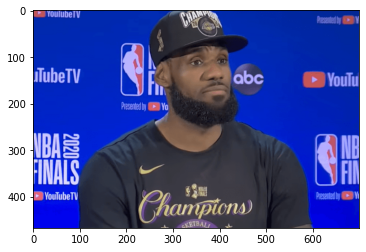

In [7]:
#이미지 업로드
image1 = load_rgb("s9.png")
imshow(image1)

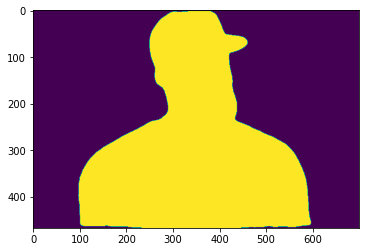

In [8]:
#마스크 생성
transform = albu.Compose([albu.Normalize(p=1)], p=1)
padded_image, pads = pad(image1, factor=32, border=cv2.BORDER_CONSTANT)
x = transform(image=padded_image)["image"]
x = torch.unsqueeze(tensor_from_rgb_image(x), 0)
with torch.no_grad():
  prediction = model(x)[0][0]
mask = (prediction > 0).cpu().numpy().astype(np.uint8)
mask = unpad(mask, pads)
imshow(mask)

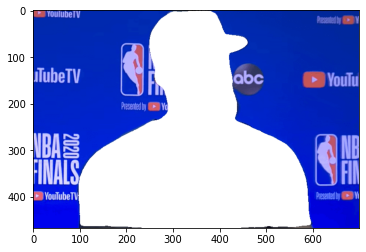

In [9]:
#이미지 + 마스크
dst = cv2.addWeighted(image1, 1, (cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB) * (255, 255, 255)).astype(np.uint8), 255, 0)
imshow(dst)

In [10]:
#마스크가 씌워진 이미지 저장
cv2.imwrite("pss.jpg",dst)

True

In [11]:
#이미지에서 글자 인식
reader = easyocr.Reader(['ko','en']) # need to run only once to load model into memory
result = reader.readtext('pss.jpg')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [12]:
#인식된 글자들 박스위치와 글자 
for one in result:
    print(one)

([[26, 0], [108, 0], [108, 22], [26, 22]], 'Voululbell', 0.3376596647283679)
([[604, 8], [662, 8], [662, 32], [604, 32]], 'Kmali', 0.20938428572516338)
([[0, 116], [108, 116], [108, 164], [0, 164]], 'IlubeTV', 0.5933448225672051)
([[425, 123], [501, 123], [501, 167], [425, 167]], 'aobc', 0.3070613145828247)
([[625, 129], [700, 129], [700, 169], [625, 169]], 'Vouli', 0.4308481096729287)
([[186, 194], [246, 194], [246, 218], [186, 218]], 'Mipoomtpl', 0.03230103062781051)
([[0, 254], [110, 254], [110, 328], [0, 328]], '[매물', 0.48462514164172626)
([[656, 266], [700, 266], [700, 328], [656, 328]], 'I', 0.21635495620397993)
([[0, 313], [111, 313], [111, 381], [0, 381]], 'TR', 0.03284145501377964)
([[654, 320], [700, 320], [700, 376], [654, 376]], 'FII', 0.119728272714841)
([[20, 386], [100, 386], [100, 412], [20, 412]], 'VoulubeT}', 0.7238024563558253)
([[602, 386], [662, 386], [662, 410], [602, 410]], 'Healll)', 0.01357235113076948)


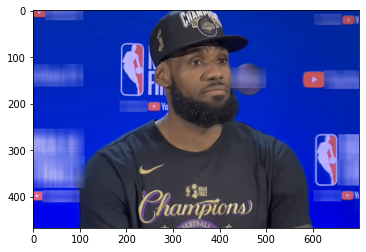

In [13]:
#블러 처리
ksize = 30              
img = image1    
for i in range(len(result)):
               x= int(result[i][0][0][0])
               y = int(result[i][0][0][1])
               w = int(result[i][0][2][0] - result[i][0][0][0])
               h = int(result[i][0][2][1] - result[i][0][0][1])
               roi = img[y:y+h, x:x+w]
               roi = cv2.blur(roi, (ksize, ksize))
               img[y:y+h, x:x+w] = roi

imshow(img)

In [14]:
#최종적으로 처리된 이미지 반환
cv2.imwrite("result.jpg",img)

True